In [1]:
print("hello")

hello


Loading model: Qwen/Qwen2.5-7B-Instruct...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Total samples: 20


Extracting features: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


Feature shape: (20, 29, 3584) (Samples, Layers, Dim)
Sweeping layers...


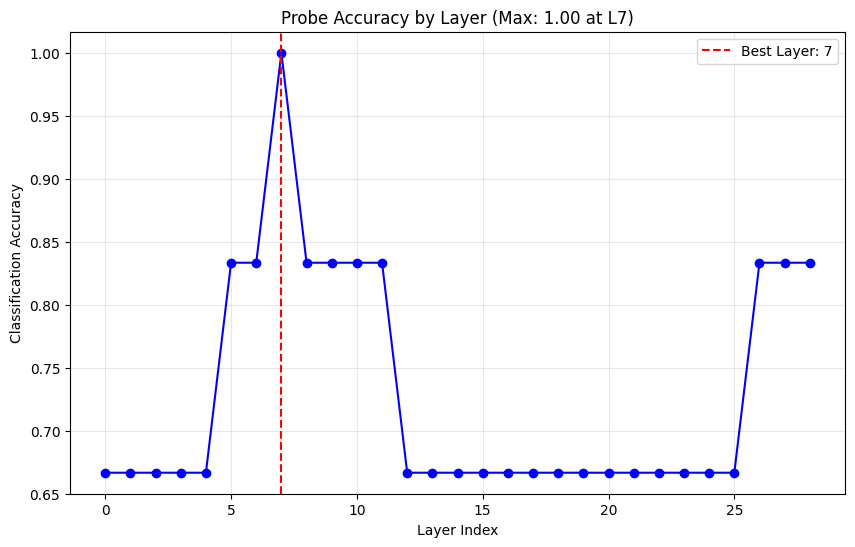

★ 結論: このタスクにおいて、最も情報量が豊富なのは Layer 7 です。
  (Layer 24 と比較してどうでしたか？ もし大きく違うなら変更すべきです)


In [ ]:
# ============================================================
# Notebook Cell 1: Setup & Data Prep
# ============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# モデル設定 (使用中のモデルに合わせてください)
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, 
    torch_dtype=torch.float16, 
    device_map="auto"
)
model.eval()

# 比較用のデータセット作成
# ここでは「創造的(Positive)」vs「事務的/事実的(Negative)」のテキストを用意します。
# ※本来は実際のデータセットを使うのがベストですが、傾向を見るにはこれでも十分です。

creative_texts = [
    "The clock melted, dripping moments onto the floor like honey.",
    "A dragon made of starlight whispered secrets to the moon.",
    "Time is not a line, but a chaotic ocean of memories.",
    "The shadows danced a tango with the flickering candlelight.",
    "Her laughter was a kaleidoscope of colors in the grey room.",
    "The city breathed, inhaling smog and exhaling neon lights.",
    "Silence screamed louder than any explosion.",
    "Dreams are the unauthorized biography of our souls.",
    "The universe is just a marble in the pocket of a giant child.",
    "Ideas are butterflies; pin them down and they die.",
    # ... (本来はもっと数が必要です: 100件程度あると信頼性が増します)
]

factual_texts = [
    "The meeting is scheduled for 2 PM in the conference room.",
    "Water boils at 100 degrees Celsius at sea level.",
    "The capital of Japan is Tokyo.",
    "Please submit your report by the end of the business day.",
    "The Pythagorean theorem states that a squared plus b squared equals c squared.",
    "Qwen is a large language model developed by Alibaba Cloud.",
    "The train departs at 08:30 from platform 4.",
    "Photosynthesis is the process by which plants make food.",
    "To install the package, run pip install numpy.",
    "The GDP of the country grew by 2.5% last year.",
    # ...
]
import random

texts = (creative_texts * 10) + (factual_texts * 10)
labels = ([1] * len(creative_texts) * 10) + ([0] * len(factual_texts) * 10)

# シャッフル
combined = list(zip(texts, labels))
random.shuffle(combined)
texts, labels = zip(*combined)
texts = list(texts)
labels = list(labels)

print(f"Total samples: {len(texts)}")

# ============================================================
# Notebook Cell 2: Feature Extraction (All Layers)
# ============================================================
def extract_hidden_states(model, tokenizer, texts, device):
    """全層のHidden States (Last Token) を抽出する"""
    all_hidden_states = [] # List of [Batch, Layers, Dim]
    
    batch_size = 4
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting features"):
        batch_texts = texts[i : i + batch_size]
        
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            
        # outputs.hidden_states は (Layer0, Layer1, ..., LayerN) のタプル
        # 各要素は [Batch, Seq, Dim]
        
        batch_layer_features = []
        
        # 各層について処理
        for layer_idx, layer_hidden in enumerate(outputs.hidden_states):
            # [Batch, Seq, Dim] -> [Batch, Dim] (Last Token Pooling)
            # ※ EOSトークン、もしくは最後の有効なトークンのベクトルを使います
            # ここでは簡易的にシーケンスの最後のトークンを使います
            last_token_hidden = layer_hidden[:, -1, :].cpu().numpy()
            batch_layer_features.append(last_token_hidden)
            
        # batch_layer_features: [Layers, Batch, Dim] -> Transpose to [Batch, Layers, Dim]
        batch_layer_features = np.array(batch_layer_features).transpose(1, 0, 2)
        all_hidden_states.append(batch_layer_features)
        
    # [Total_Samples, Layers, Dim]
    return np.concatenate(all_hidden_states, axis=0)

features = extract_hidden_states(model, tokenizer, texts, device)
print(f"Feature shape: {features.shape} (Samples, Layers, Dim)")

# ============================================================
# Notebook Cell 3: Probe Sweeping (Train Linear Probe per Layer)
# ============================================================
layer_accuracies = []
num_layers = features.shape[1]

X = features
y = np.array(labels)

print("Sweeping layers...")
for layer_idx in range(num_layers):
    # その層の特徴量を取得
    X_layer = X[:, layer_idx, :]
    
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_layer, y, test_size=0.3, random_state=42)
    
    # 簡易的なロジスティック回帰で線形分離性をテスト
    # (ここが高い＝その層で「創造性」が明確に表現されている)
    clf = LogisticRegression(max_iter=1000, solver='liblinear')
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    
    layer_accuracies.append(acc)
    # print(f"Layer {layer_idx}: Accuracy = {acc:.3f}")

# ============================================================
# Notebook Cell 4: Visualization
# ============================================================
best_layer = np.argmax(layer_accuracies)
best_acc = layer_accuracies[best_layer]

plt.figure(figsize=(10, 6))
plt.plot(range(num_layers), layer_accuracies, marker='o', linestyle='-', color='b')
plt.axvline(best_layer, color='r', linestyle='--', label=f'Best Layer: {best_layer}')
plt.title(f"Probe Accuracy by Layer (Max: {best_acc:.2f} at L{best_layer})")
plt.xlabel("Layer Index")
plt.ylabel("Classification Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"★ 結論: このタスクにおいて、最も情報量が豊富なのは Layer {best_layer} です。")
print(f"  (Layer 24 と比較してどうでしたか？ もし大きく違うなら変更すべきです)")